# ATLAS $H \rightarrow ZZ \rightarrow \ell \ell \ell \ell$ Public Outreach Example

ATLAS has released its higgs discovery dataset as public data:

* Use `ServiceX` to stream the 4 lepton data
* Use `coffea` and `awkward` to produce the final $m_{4\ell}$ plots.

Outline

1. Use `ServiceX` for general quality and object selection
1. Use `coffea` and `awkward` to do multi-object event wide selection and plots
1. Produce the plot for running on a single MC file
1. Run on all the MC and Data files

In [119]:
from func_adl_servicex import ServiceXSourceUpROOT
from servicex.servicex import ServiceXDataset
from coffea.processor.servicex import Analysis, DataSource, LocalExecutor
from func_adl import ObjectStream
from hist import Hist

import asyncio
from typing import List

## Selecting events and clean objects

The ATLAS analysis ...

First we create the representative data source, and apply the initial trigger requirement:

In [120]:
ds = ServiceXSourceUpROOT('cernopendata://dummy',  "mimi", backend='open_uproot')
ds.return_qastle = True  # Magic

good_events = (ds
               .Where(lambda e: e.trigE or e.trigM)
              )

Next, basic lepton selection:

* Turn the columnar representation into object so we can make cuts
* Apply the common base cuts for electrons and muons
* We also need the event weights, which are baked into the ntuple

In [121]:
all_leptons = (good_events
                .Select(lambda e: (
                    Zip({
                        'lep_pt': e.lep_pt,
                        'lep_eta': e.lep_eta,
                        'lep_phi': e.lep_phi,
                        'lep_energy': e.lep_E,
                        'lep_charge': e.lep_charge,
                        'lep_ptcone30': e.lep_ptcone30,
                        'lep_etcone20': e.lep_etcone20,
                        'lep_typeid': e.lep_type,
                        'lep_trackd0pvunbiased': e.lep_trackd0pvunbiased,
                        'lep_tracksigd0pvunbiased': e.lep_tracksigd0pvunbiased,
                        'lep_z0': e.lep_z0,
                    }),
                    e.mcWeight,
                    e.scaleFactor_ELE*e.scaleFactor_MUON*e.scaleFactor_LepTRIGGER*e.scaleFactor_PILEUP,
                ))
               )

In [122]:
good_leptons = (all_leptons
                .Select(lambda e: {
                    'ele': e[0]
                           .Where(lambda lep: lep.lep_typeid == 11)
                           .Where(lambda lep: (lep.lep_pt > 7000)
                                              and (abs(lep.lep_eta) < 2.47)
                                              and (lep.lep_etcone20/lep.lep_pt < 0.3)
                                              and (lep.lep_ptcone30/lep.lep_pt < 0.3)
                                              and (abs(lep.lep_trackd0pvunbiased) / lep.lep_tracksigd0pvunbiased < 5)
                                 ),
                    'mu': e[0]
                           .Where(lambda lep: lep.lep_typeid == 13)
                           .Where(lambda lep: (lep.lep_pt > 5000)
                                              and (abs(lep.lep_eta) < 2.5)
                                              and (lep.lep_etcone20/lep.lep_pt < 0.3)
                                              and (lep.lep_ptcone30/lep.lep_pt < 0.3)
                                              and (abs(lep.lep_trackd0pvunbiased) / lep.lep_tracksigd0pvunbiased < 3)
                                 ),
                    'mcWeight': e[1],
                    'scaleFactor': e[2],
                })
               )

And finally, we have to turn this into a form that coffea can currently understand.

* We only need to feed columns we will use downstream out of `ServiceX`, reducing the dataload.

In [123]:
atlas_selection = (good_leptons
                   .Select(lambda e: {
                       'electrons_pt': e.ele.lep_pt,
                       'electrons_eta': e.ele.lep_eta,
                       'electrons_phi': e.ele.lep_phi,
                       'electrons_energy': e.ele.lep_energy,
                       'electrons_charge': e.ele.lep_charge,
                       'electrons_z0': e.ele.lep_z0,
                       'muons_pt': e.mu.lep_pt,
                       'muons_eta': e.mu.lep_eta,
                       'muons_phi': e.mu.lep_phi,
                       'muons_energy': e.mu.lep_energy,
                       'muons_charge': e.mu.lep_charge,
                       'muons_z0': e.mu.lep_z0,
                       'mcWeight': e.mcWeight,
                       'scaleFactor': e.scaleFactor,
                   })
                   .AsParquetFiles('junk.parquet')
                  )

## Performing the analysis

The data from `ServiceX` is now analyzed by `awkward` and `coffea`.

* `coffea` automatically builds _event_ layout for electorns and muons, queuing off the prefix in the names from `ServiceX`
* `coffea` recognizes that $p_T$, $\eta$, $\phi$, and $E$ are availible, and builds a 4-vector that has a `theta` property.
* `awkward` properly translates the `np.sin` to work on an `awkward` array.

## Run on a MC file

Define a convience function to load MC files - there are a lot of them.

* Note the `is_data` metadata - which was used above in an if statement

In [138]:
def make_ds(name: str, query: ObjectStream):
    '''Create a ServiceX Datasource for a particular ATLAS Open data file
    '''
    from utils import files
    is_data = name == 'data'
    datasets = [ServiceXDataset(files[name]['files'], backend_type='open_uproot', image='sslhep/servicex_func_adl_uproot_transformer:pr_fix_awk_bug')]
    return DataSource(query=query, metadata={'dataset': name, 'is_data': is_data}, datasets=datasets)

In [139]:
from utils import files
all_datasets = list(files.keys())
', '.join(all_datasets)

'data, ggH125_ZZ4lep, ZH125_ZZ4lep, VBFH125_ZZ4lep, WH125_ZZ4lep, ZqqZll, WpqqWmlv, WplvWmqq, WlvZqq, llll, lllv, llvv, lvvv, Zee, Zmumu, Ztautau'

And an easy routine that will run a single file

* Async so we can run multiple queires at once
* Contains a lot of boiler plate
* Runs on multiple datasets at once (which we will need)

In [150]:
async def run_analysis(names: List[str]):
    'Generate base plot for a multiple datafiles'

    executor = LocalExecutor(datatype='parquet')
    datasources = [make_ds(ds_name, atlas_selection) for ds_name in names]

    # Create the analysis and we can run from there.
    analysis = ATLAS_Higgs_4L()

    async def run_updates_stream(accumulator_stream, name):
        '''Run to get the last item in the stream, with a useful error message'''
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f'Failure while processing {name}') from e
        return coffea_info

    # Run on all items and wait till they are done!
    all_plots = await asyncio.gather(*[run_updates_stream(executor.execute(analysis, source), source.metadata['dataset']) for source in datasources])
    
    all_plots_mass = [p['mass'] for p in all_plots]
    mass = all_plots_mass[0]
    for p in all_plots_mass[1:]:
        mass += p

    return mass

In [151]:
mc_mass_plot = await run_analysis(['ggH125_ZZ4lep'])

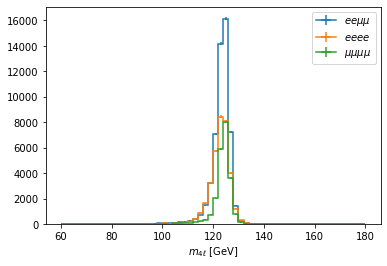

In [152]:
artists = mc_mass_plot.project('mass','channel').plot()
ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

No handles with labels found to put in legend.


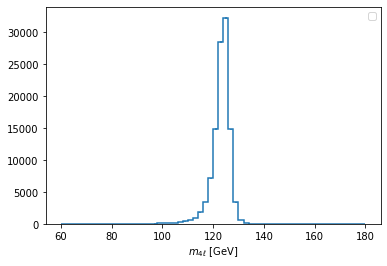

In [153]:
artists = mc_mass_plot.project('mass').plot()
ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

## Running on all MC and Data Files

Here we will repeat the above, but unleash it on all our datasets. These will all be put into a single histogram, with the `dataset` bin marking what sample they are from.

In [154]:
mass_plot = await run_analysis(all_datasets)

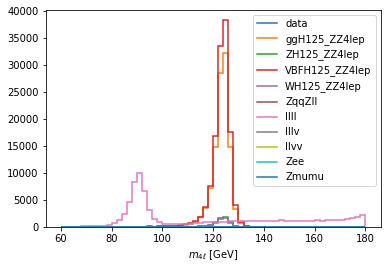

In [155]:
artists = mass_plot.project('mass', 'dataset').plot()
ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

First, lets look at the components. We'd like signal, data, and the sum of everything else (MC prediction).

Data:

No handles with labels found to put in legend.


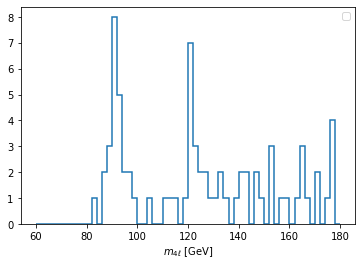

In [160]:
artists = mass_plot[:, 'data', :].project('mass').plot()
ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

Signal:

No handles with labels found to put in legend.


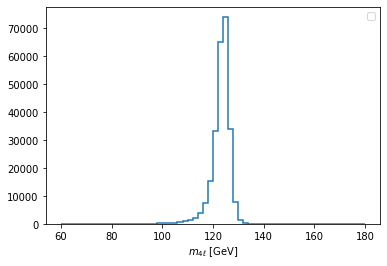

In [169]:
signal_ds = tuple(d for d in all_datasets if 'H125' in d)
signal_plot = sum(mass_plot[:, h_name, :] for h_name in signal_ds)
artists = signal_plot.project('mass').plot()
ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

Sum of the backgrounds:

No handles with labels found to put in legend.


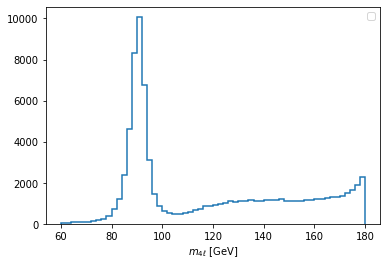

In [171]:
mc_ds = set(all_datasets) - set(signal_ds) - set(['data'])
signal_plot = sum(mass_plot[:, h_name, :] for h_name in mc_ds)
artists = signal_plot.project('mass').plot()
ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");